This notebook will give you a taste for the steps of EDA and preprocessing the data monday is supplying 

In [0]:
# import section

import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import missingno

## Load the data

we'll focus on the 2 main tables - users and accounts. You have more data about subscriptions and events - probably you should use it too.


In [170]:
users_df = pd.read_csv('https://storage.googleapis.com/mondaycom-datahack/final_sets/train_users.csv', nrows=700000000000)
accounts_df = pd.read_csv('https://storage.googleapis.com/mondaycom-datahack/final_sets/train_accounts.csv', nrows=7000000000)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lets have a quick peek on the data 

In [171]:
accounts_df.head()

,account_id,account_name,created_at,plan_id,trial_start,churn_date,churn_reason,time_diff,region,country,subscription_started_at,paying,has_logo,device,os,browser,collection_21_days,company_size,payment_currency,max_team_size,min_team_size,industry,utm_cluster_id,mrr,user_goal,user_description,team_size,lead_score
0,1.00,"Gardner, Barron and Keller",2019-01-01 00:01:15,nan,2019-01-01 00:01:15,NaN,nan,11.00,New South Wales,AU,NaN,0,1,desktop,windows,microsoft edge,0,nan,AUD,5.00,2.00,NaN,orders,nan,NaN,NaN,NaN,0
1,2.00,Dunn Ltd,2019-01-01 00:01:52,nan,2019-01-01 00:01:52,NaN,nan,nan,New Jersey,US,NaN,0,1,mobile,ios,NaN,0,nan,USD,5.00,2.00,NaN,NaN,nan,NaN,NaN,NaN,0
2,3.00,Boone Inc,2019-01-01 00:03:12,nan,2019-01-01 00:03:12,NaN,nan,-6.00,Louisiana,US,NaN,0,1,desktop,windows,chrome,0,nan,USD,1.00,1.00,Other,todos,nan,NaN,NaN,1,0
3,4.00,"Christian, Carroll and Davis",2019-01-01 00:04:11,nan,2019-01-01 00:04:11,NaN,nan,nan,Tel Aviv,IL,NaN,0,1,mobile,android,NaN,0,nan,USD,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,0
4,5.00,Brooks-Oliver,2019-01-01 00:04:21,nan,2019-04-04 11:09:12,NaN,nan,-5.00,North Carolina,US,NaN,0,1,desktop,chrome_os,chrome,0,nan,USD,1.00,1.00,Design,todos,nan,NaN,NaN,1,0


In [172]:
accounts_df.shape

(1361978, 28)

In [173]:
(pd.to_datetime(accounts_df['trial_start']) - pd.to_datetime(accounts_df['created_at'])).apply(lambda x: (x.seconds//3600))

0           0
1           0
2           0
3           0
4          11
5           0
6           3
7           0
8           0
9           0
10          0
11         22
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
           ..
1361948     0
1361949    22
1361950     0
1361951     0
1361952     0
1361953     0
1361954     0
1361955     0
1361956     0
1361957     0
1361958     0
1361959     0
1361960     0
1361961     0
1361962     0
1361963     0
1361964     0
1361965     0
1361966     0
1361967     0
1361968     0
1361969     0
1361970     0
1361971    17
1361972     0
1361973     0
1361974     0
1361975     0
1361976     0
1361977     0
Length: 1361978, dtype: int64

# Data exploration

## General statistics

Lets do some basic exploration on some of the columns to get some feeling what we are dealing with

In [174]:
accounts_df.describe(include='all')

,account_id,account_name,created_at,plan_id,trial_start,churn_date,churn_reason,time_diff,region,country,subscription_started_at,paying,has_logo,device,os,browser,collection_21_days,company_size,payment_currency,max_team_size,min_team_size,industry,utm_cluster_id,mrr,user_goal,user_description,team_size,lead_score
count,"1,361,978.00",1361978,1361978,"28,603.00",1361978,2882,"23,931.00","1,132,187.00",1273478,1342302,32172,"1,361,978.00","1,361,978.00",1361978,1361893,1169842,"1,361,978.00","283,482.00",1353987,"1,214,368.00","1,214,368.00",870861,661787,"45,603.00",485189,309064,954830,"1,361,978.00"
unique,nan,512268,1293250,nan,1295949,2845,nan,nan,3578,236,32124,nan,nan,3,7,12,nan,nan,8,nan,nan,32,27,nan,3,5,18,nan
top,nan,Smith PLC,2019-02-19 16:24:32,nan,2019-04-29 13:35:08,2019-07-01 16:05:29,nan,nan,Sao Paulo,US,2019-05-21 15:53:21,nan,nan,desktop,windows,chrome,nan,nan,USD,nan,nan,Other,todos,nan,work,team_lead,2-5,nan
freq,nan,4540,5,nan,6,3,nan,nan,54021,314456,3,nan,nan,969039,716793,844715,nan,nan,1047830,nan,nan,103596,198206,nan,311841,101379,352333,nan
mean,"716,900.82",NaN,NaN,441.50,NaN,NaN,14.74,-1.44,NaN,NaN,NaN,0.02,1.00,NaN,NaN,NaN,7.74,"10,968.07",NaN,17.58,10.91,NaN,NaN,38.94,NaN,NaN,NaN,0.02
std,"413,825.27",NaN,NaN,411.82,NaN,NaN,3.27,4.72,NaN,NaN,NaN,0.14,0.00,NaN,NaN,NaN,102.77,"59,414.67",NaN,68.50,53.19,NaN,NaN,69.31,NaN,NaN,NaN,0.16
min,1.00,NaN,NaN,9.00,NaN,NaN,1.00,-12.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,"-1,440.00",1.00,NaN,0.00,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00
25%,"358,615.25",NaN,NaN,208.00,NaN,NaN,13.00,-5.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,30.00,NaN,1.00,1.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00
50%,"716,953.50",NaN,NaN,232.00,NaN,NaN,15.00,-3.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,210.00,NaN,5.00,2.00,NaN,NaN,25.00,NaN,NaN,NaN,0.00
75%,"1,075,187.75",NaN,NaN,816.00,NaN,NaN,18.00,2.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,"2,750.00",NaN,10.00,6.00,NaN,NaN,48.00,NaN,NaN,NaN,0.00


Its really annoying to look on those numbers - lets fix the formating

In [0]:
pd.options.display.float_format = '{:,.2f}'.format

In [176]:
accounts_df.describe(include='all')

,account_id,account_name,created_at,plan_id,trial_start,churn_date,churn_reason,time_diff,region,country,subscription_started_at,paying,has_logo,device,os,browser,collection_21_days,company_size,payment_currency,max_team_size,min_team_size,industry,utm_cluster_id,mrr,user_goal,user_description,team_size,lead_score
count,"1,361,978.00",1361978,1361978,"28,603.00",1361978,2882,"23,931.00","1,132,187.00",1273478,1342302,32172,"1,361,978.00","1,361,978.00",1361978,1361893,1169842,"1,361,978.00","283,482.00",1353987,"1,214,368.00","1,214,368.00",870861,661787,"45,603.00",485189,309064,954830,"1,361,978.00"
unique,nan,512268,1293250,nan,1295949,2845,nan,nan,3578,236,32124,nan,nan,3,7,12,nan,nan,8,nan,nan,32,27,nan,3,5,18,nan
top,nan,Smith PLC,2019-02-19 16:24:32,nan,2019-04-29 13:35:08,2019-07-01 16:05:29,nan,nan,Sao Paulo,US,2019-05-21 15:53:21,nan,nan,desktop,windows,chrome,nan,nan,USD,nan,nan,Other,todos,nan,work,team_lead,2-5,nan
freq,nan,4540,5,nan,6,3,nan,nan,54021,314456,3,nan,nan,969039,716793,844715,nan,nan,1047830,nan,nan,103596,198206,nan,311841,101379,352333,nan
mean,"716,900.82",NaN,NaN,441.50,NaN,NaN,14.74,-1.44,NaN,NaN,NaN,0.02,1.00,NaN,NaN,NaN,7.74,"10,968.07",NaN,17.58,10.91,NaN,NaN,38.94,NaN,NaN,NaN,0.02
std,"413,825.27",NaN,NaN,411.82,NaN,NaN,3.27,4.72,NaN,NaN,NaN,0.14,0.00,NaN,NaN,NaN,102.77,"59,414.67",NaN,68.50,53.19,NaN,NaN,69.31,NaN,NaN,NaN,0.16
min,1.00,NaN,NaN,9.00,NaN,NaN,1.00,-12.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,"-1,440.00",1.00,NaN,0.00,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00
25%,"358,615.25",NaN,NaN,208.00,NaN,NaN,13.00,-5.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,30.00,NaN,1.00,1.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00
50%,"716,953.50",NaN,NaN,232.00,NaN,NaN,15.00,-3.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,210.00,NaN,5.00,2.00,NaN,NaN,25.00,NaN,NaN,NaN,0.00
75%,"1,075,187.75",NaN,NaN,816.00,NaN,NaN,18.00,2.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,0.00,"2,750.00",NaN,10.00,6.00,NaN,NaN,48.00,NaN,NaN,NaN,0.00


Now we can see interesting stuff regarding some of the features, for example:
* We can see that there is a significant imbalance with our labels - we will need to handle that later in the modeling phase
* both paying and lead_score have a mean of 0.02, will be very interesting to see if they are correlated 
* team_size is a categorical feature that represents a range of values, and we have a lot of samples that got min_team_size and max_team_size but not team_size
* we have more non-null churn_reason than churn_date - we will need to think how to handle the different cases.


## Graphs

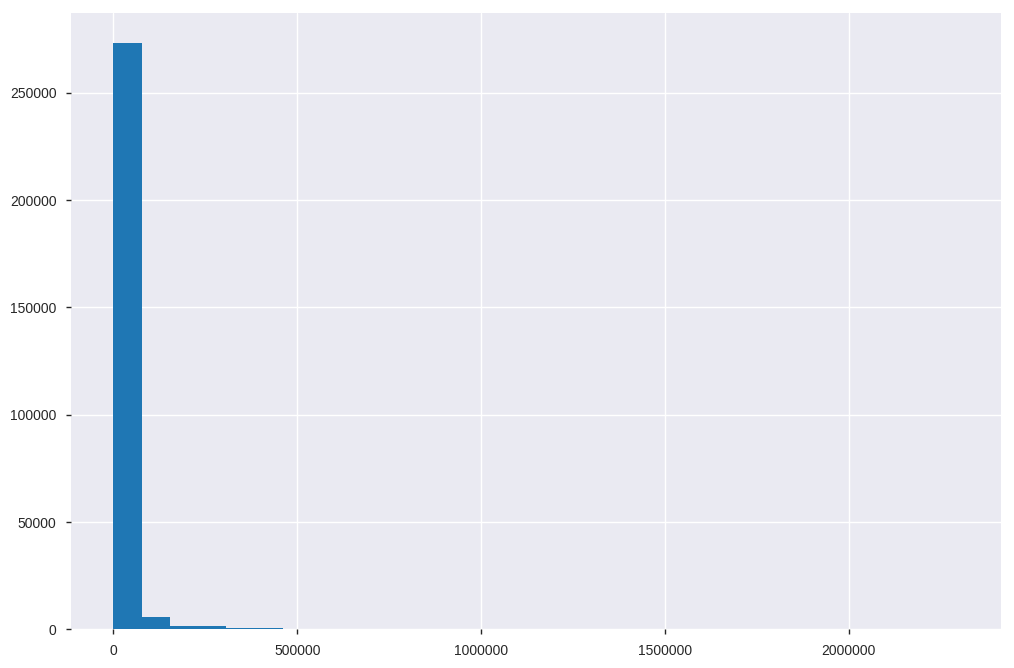

In [177]:
accounts_df['company_size'].hist(figsize=(12,8), bins=30)


And we can split it also by the label to see if there is some interesting difference between the distributions:

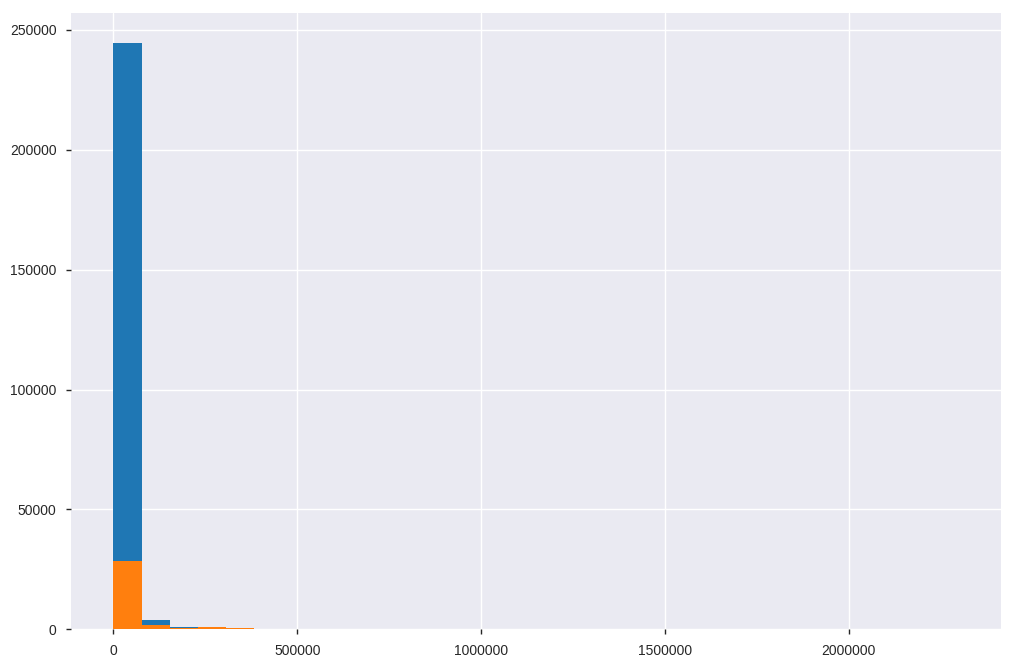

In [178]:
accounts_df[accounts_df['lead_score'] == 0]['company_size'].hist(figsize=(12,8), bins=30)
accounts_df[accounts_df['lead_score'] == 1]['company_size'].hist(figsize=(12,8), bins=30)


With focus on the main area of the data (and with a legend :) )

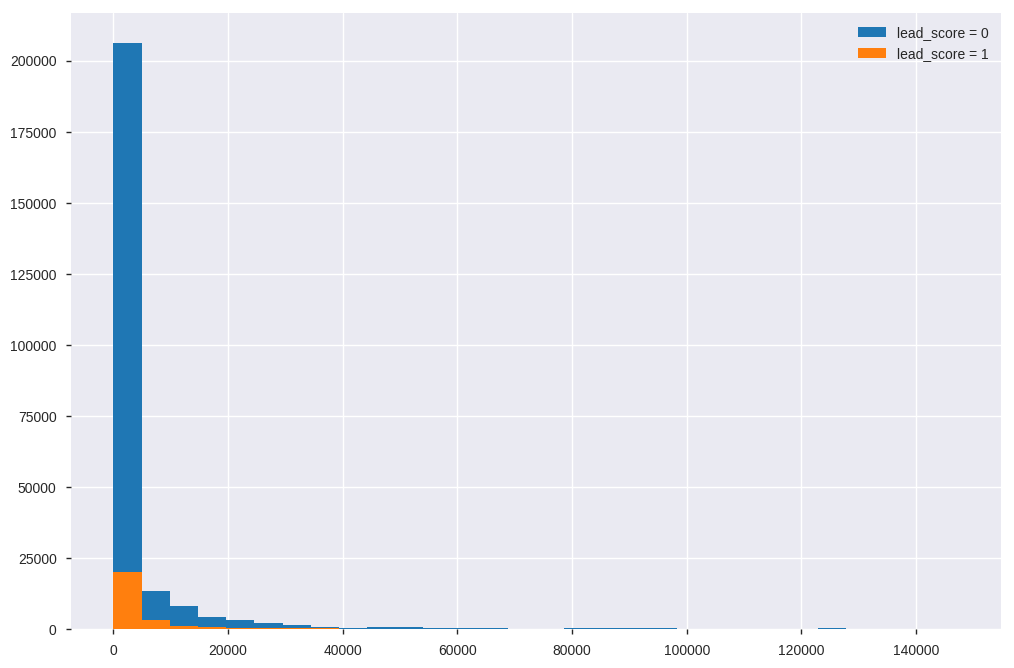

In [179]:
accounts_df[(accounts_df['lead_score'] == 0) & (accounts_df['company_size']<150000)].company_size.hist(figsize=(12,8), bins=30, label='lead_score = 0')
accounts_df[(accounts_df['lead_score'] == 1) & (accounts_df['company_size']<150000)].company_size.hist(figsize=(12,8), bins=30, label='lead_score = 1')
plt.legend(loc='upper right')

Now lets also look on `churn_reason`

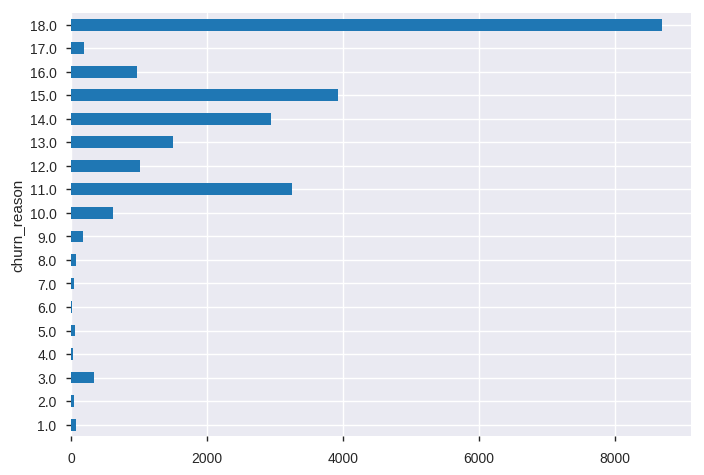

In [180]:
ax = accounts_df.groupby('churn_reason').size().plot.barh()

And `user_description`

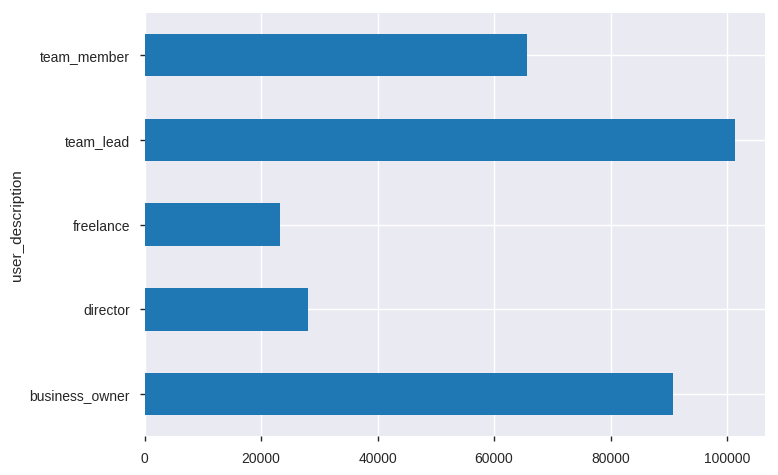

In [181]:
ax = accounts_df.groupby('user_description').size().plot.barh()

And lets look for the last one a connection between `min_team_size` and `max_team_size`:

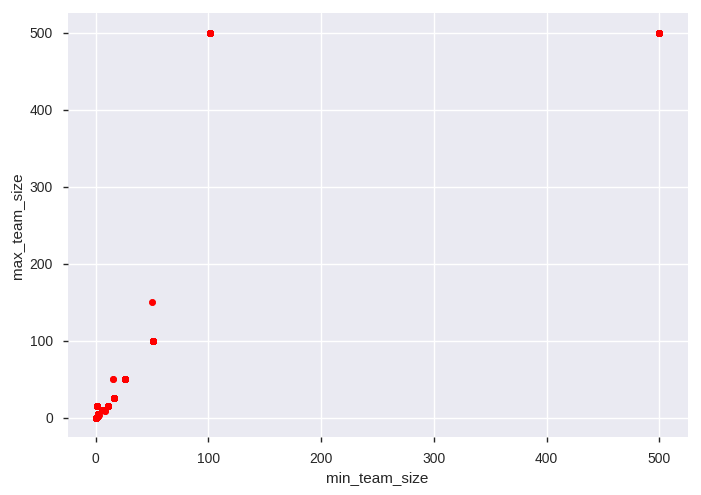

In [182]:
ax1 = accounts_df.plot.scatter(x='min_team_size', y='max_team_size', c='Red')

We can see there is a 2 extreme cases - lets focus the rest

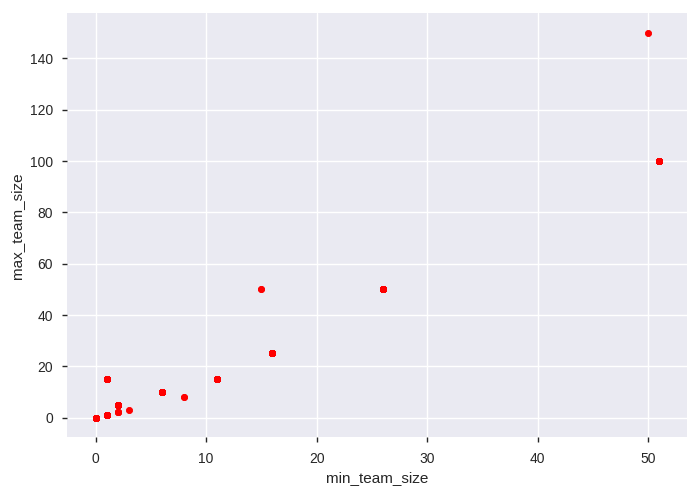

In [183]:
ax1 = accounts_df[accounts_df['max_team_size'] < 300].plot.scatter(x='min_team_size', y='max_team_size', c='Red')

## Correlation with numeric features

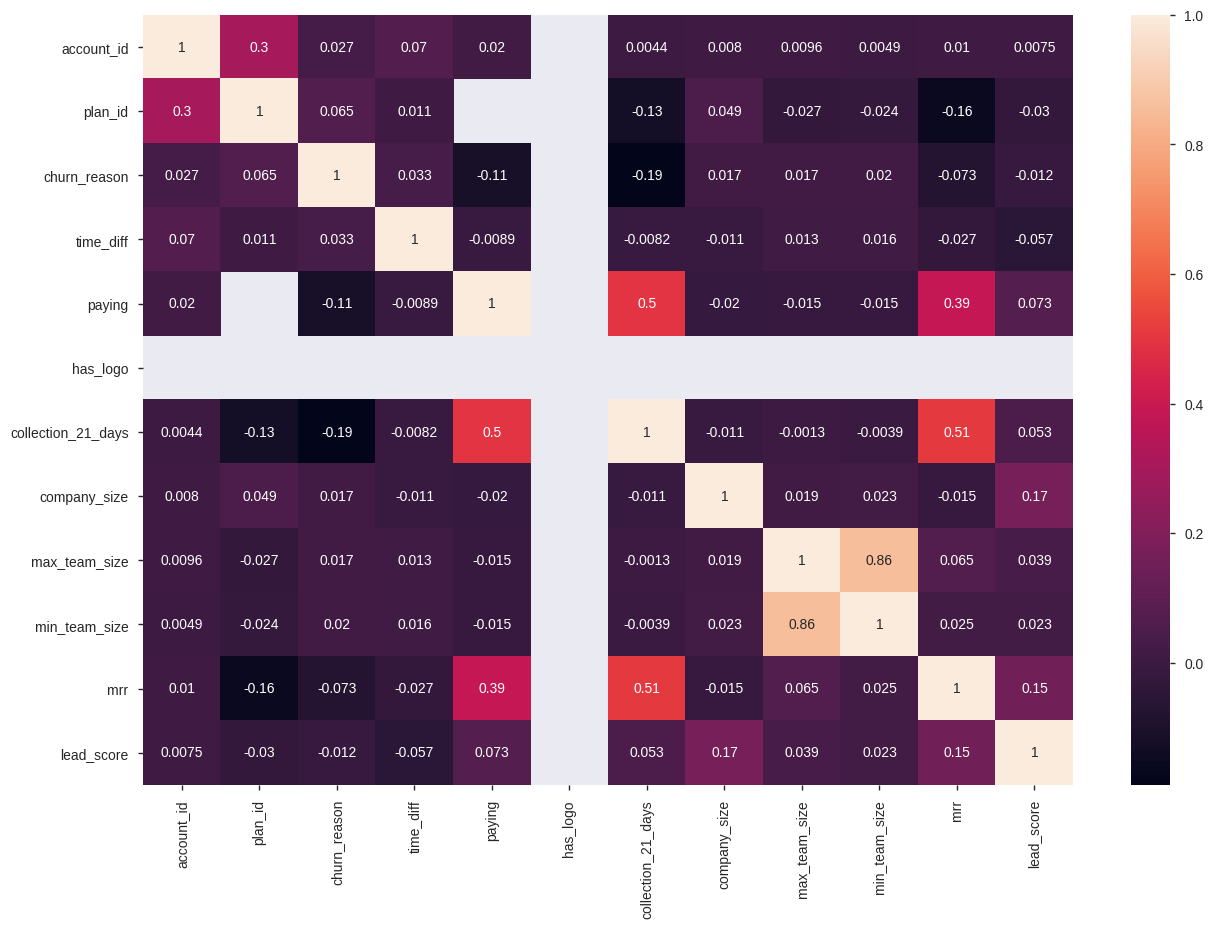

In [184]:
plt.figure(figsize=(15, 10))
sns.heatmap(accounts_df.corr(), annot=True)

In [0]:
less_missing = accounts_df[accounts_df.columns[accounts_df.isna().sum() < accounts_df.shape[0]*0.8]]

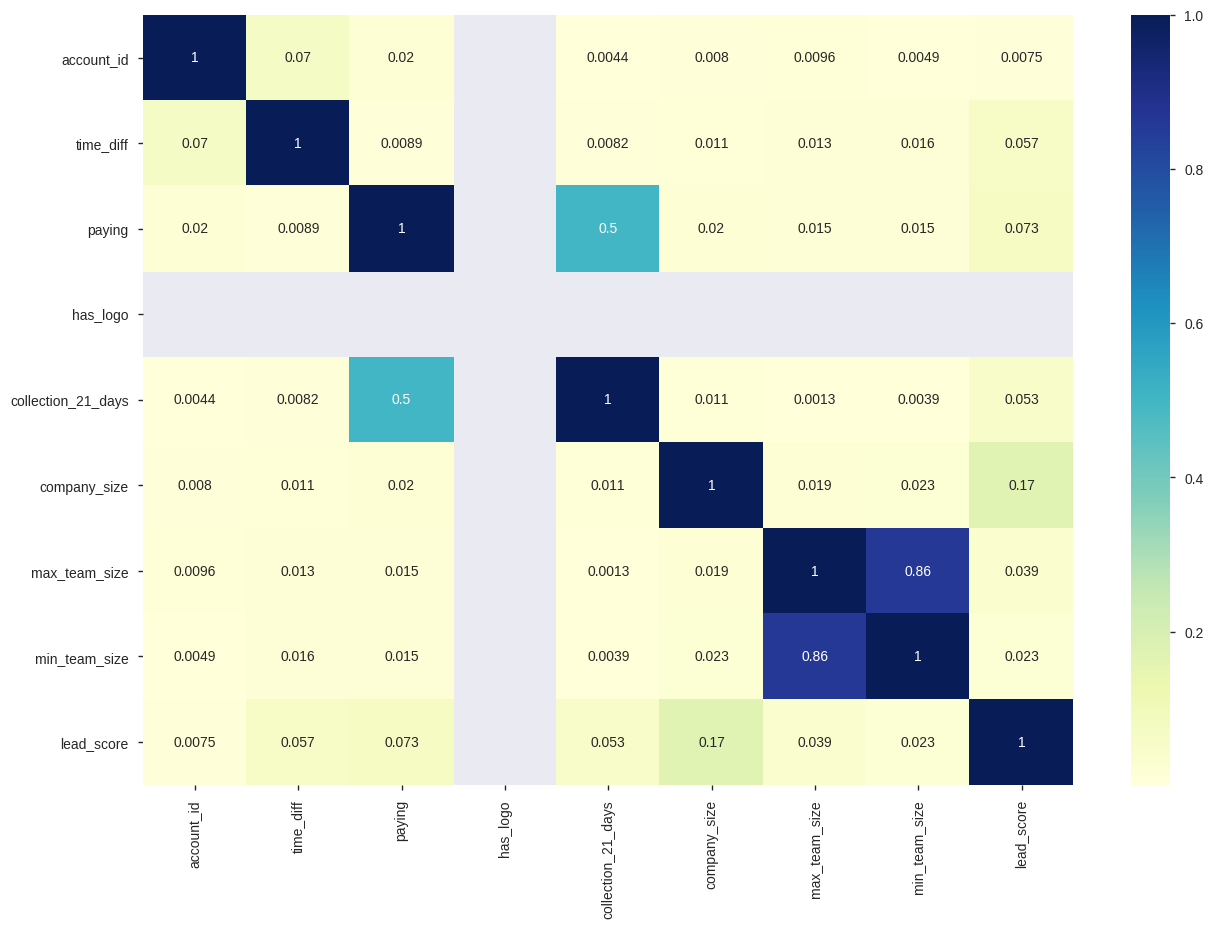

In [186]:
plt.figure(figsize=(15, 10))
sns.heatmap(abs(less_missing.corr()),cmap ="YlGnBu", annot=True)

## Your turn
take one of the columns and explore and visualize in an interesting way 

# Preprocessing

## "Useless" columns
Now let's see if we have "useless" columns that do not contain any information

In [187]:
accounts_df.nunique()

account_id                 1361976
account_name                512268
created_at                 1293250
plan_id                        113
trial_start                1295949
churn_date                    2845
churn_reason                    18
time_diff                       40
region                        3578
country                        236
subscription_started_at      32124
paying                           2
has_logo                         1
device                           3
os                               7
browser                         12
collection_21_days            1469
company_size                  4224
payment_currency                 8
max_team_size                   13
min_team_size                   14
industry                        32
utm_cluster_id                  27
mrr                            382
user_goal                        3
user_description                 5
team_size                       18
lead_score                       2
dtype: int64

You can see that we have has_logo which is constant - we should throw it away

In [0]:
index_of_useless_columns = accounts_df.nunique().isin([0,1])
columns_to_drop = np.array(accounts_df.columns)[index_of_useless_columns]
accounts_df.drop(columns=columns_to_drop, inplace=True)

In [189]:
accounts_df.head()

,account_id,account_name,created_at,plan_id,trial_start,churn_date,churn_reason,time_diff,region,country,subscription_started_at,paying,device,os,browser,collection_21_days,company_size,payment_currency,max_team_size,min_team_size,industry,utm_cluster_id,mrr,user_goal,user_description,team_size,lead_score
0,1.00,"Gardner, Barron and Keller",2019-01-01 00:01:15,nan,2019-01-01 00:01:15,NaN,nan,11.00,New South Wales,AU,NaN,0,desktop,windows,microsoft edge,0,nan,AUD,5.00,2.00,NaN,orders,nan,NaN,NaN,NaN,0
1,2.00,Dunn Ltd,2019-01-01 00:01:52,nan,2019-01-01 00:01:52,NaN,nan,nan,New Jersey,US,NaN,0,mobile,ios,NaN,0,nan,USD,5.00,2.00,NaN,NaN,nan,NaN,NaN,NaN,0
2,3.00,Boone Inc,2019-01-01 00:03:12,nan,2019-01-01 00:03:12,NaN,nan,-6.00,Louisiana,US,NaN,0,desktop,windows,chrome,0,nan,USD,1.00,1.00,Other,todos,nan,NaN,NaN,1,0
3,4.00,"Christian, Carroll and Davis",2019-01-01 00:04:11,nan,2019-01-01 00:04:11,NaN,nan,nan,Tel Aviv,IL,NaN,0,mobile,android,NaN,0,nan,USD,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,0
4,5.00,Brooks-Oliver,2019-01-01 00:04:21,nan,2019-04-04 11:09:12,NaN,nan,-5.00,North Carolina,US,NaN,0,desktop,chrome_os,chrome,0,nan,USD,1.00,1.00,Design,todos,nan,NaN,NaN,1,0


## Add additional features

Another step we would like to take - engineer new features from the current ones.

In [0]:
time_between_created_trail = pd.to_datetime(accounts_df['trial_start']) - pd.to_datetime(accounts_df['created_at'])

In [0]:
accounts_df = accounts_df.assign(created_trial_delta=time_between_created_trail.apply(lambda x: (x.seconds//3600)))

## Handling the missing values
First, we want to check some statistics about the missing data. lets see what is the fraction of missing data in each column

In [192]:
accounts_df.isnull().sum() * 100 / accounts_df.shape[0]


account_id                 0.00
account_name               0.00
created_at                 0.00
plan_id                   97.90
trial_start                0.00
churn_date                99.79
churn_reason              98.24
time_diff                 16.87
region                     6.50
country                    1.44
subscription_started_at   97.64
paying                     0.00
device                     0.00
os                         0.01
browser                   14.11
collection_21_days         0.00
company_size              79.19
payment_currency           0.59
max_team_size             10.84
min_team_size             10.84
industry                  36.06
utm_cluster_id            51.41
mrr                       96.65
user_goal                 64.38
user_description          77.31
team_size                 29.89
lead_score                 0.00
created_trial_delta        0.00
dtype: float64

There is a library called `missingno` that can help us understand the missing values in our dataset

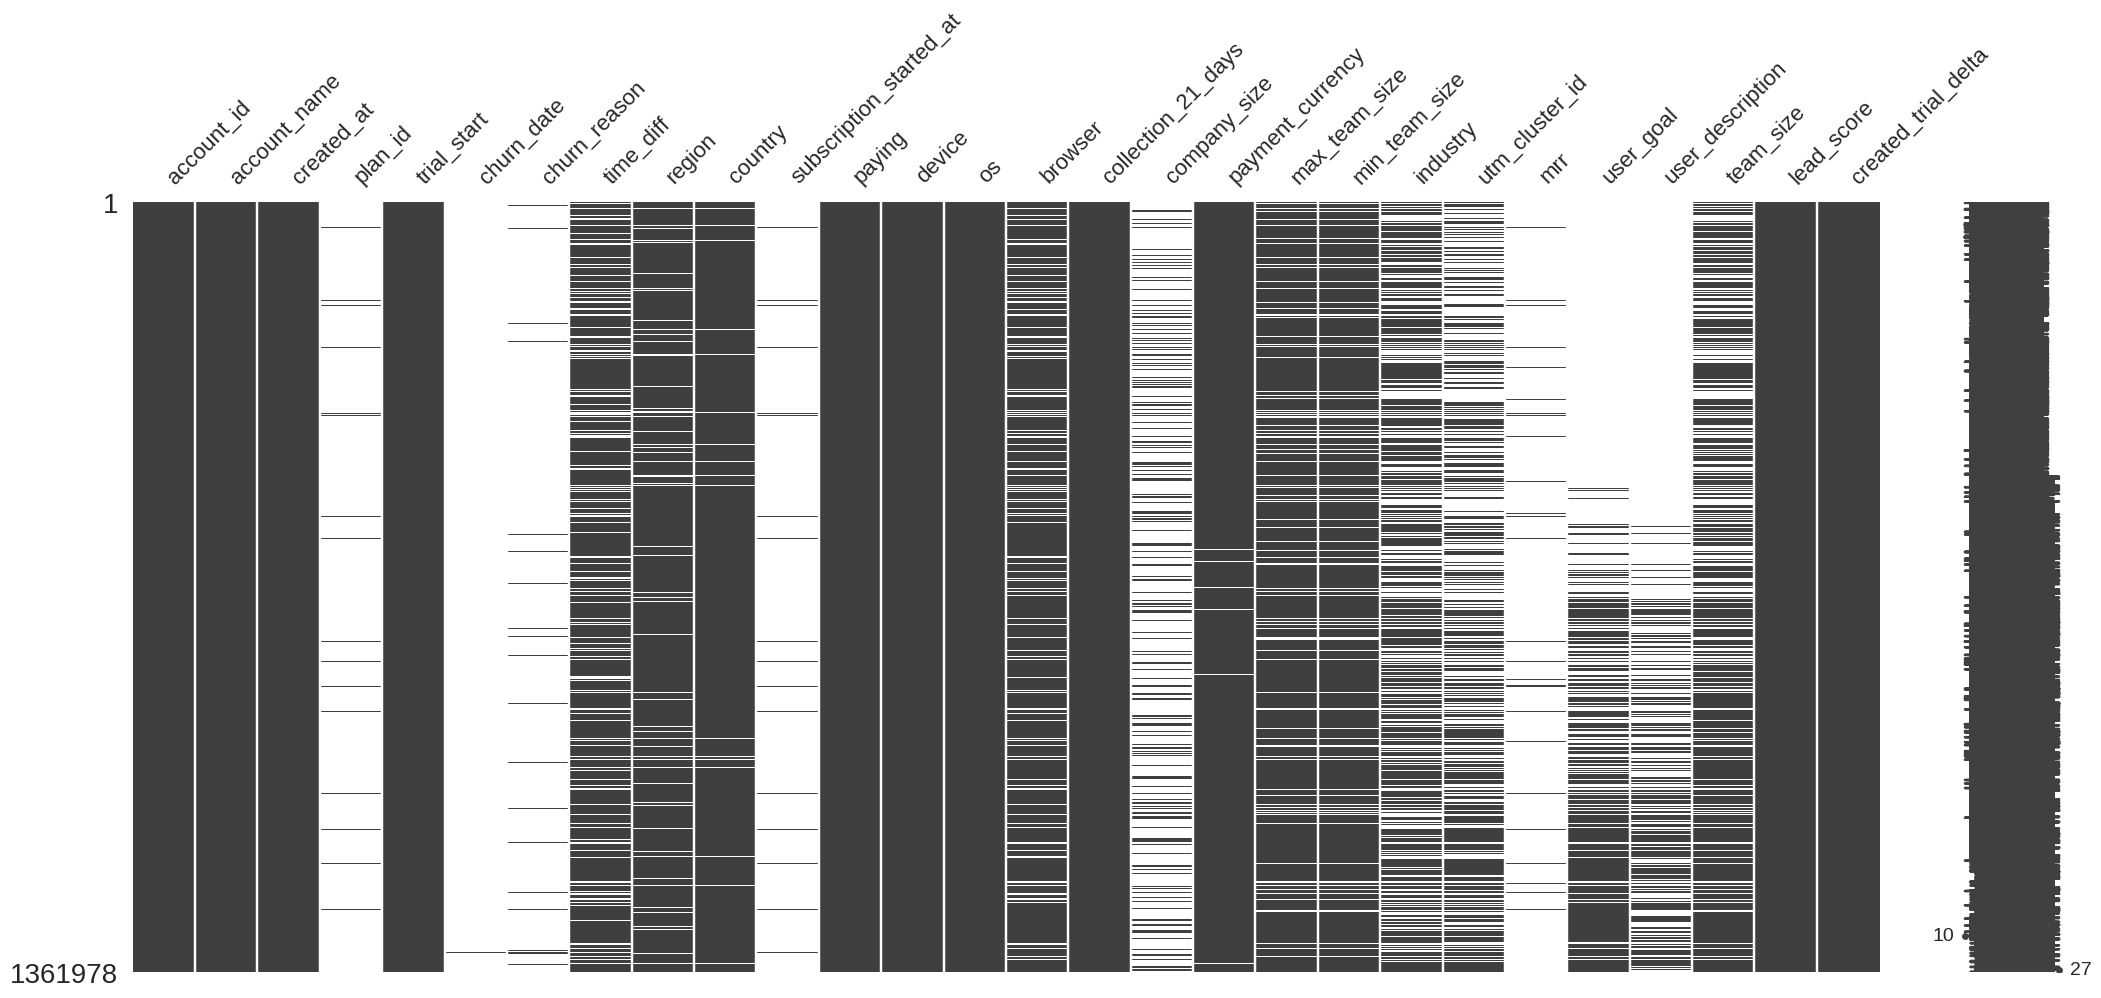

In [193]:
missingno.matrix(accounts_df)

And we can also check something that called "nullety correlation"

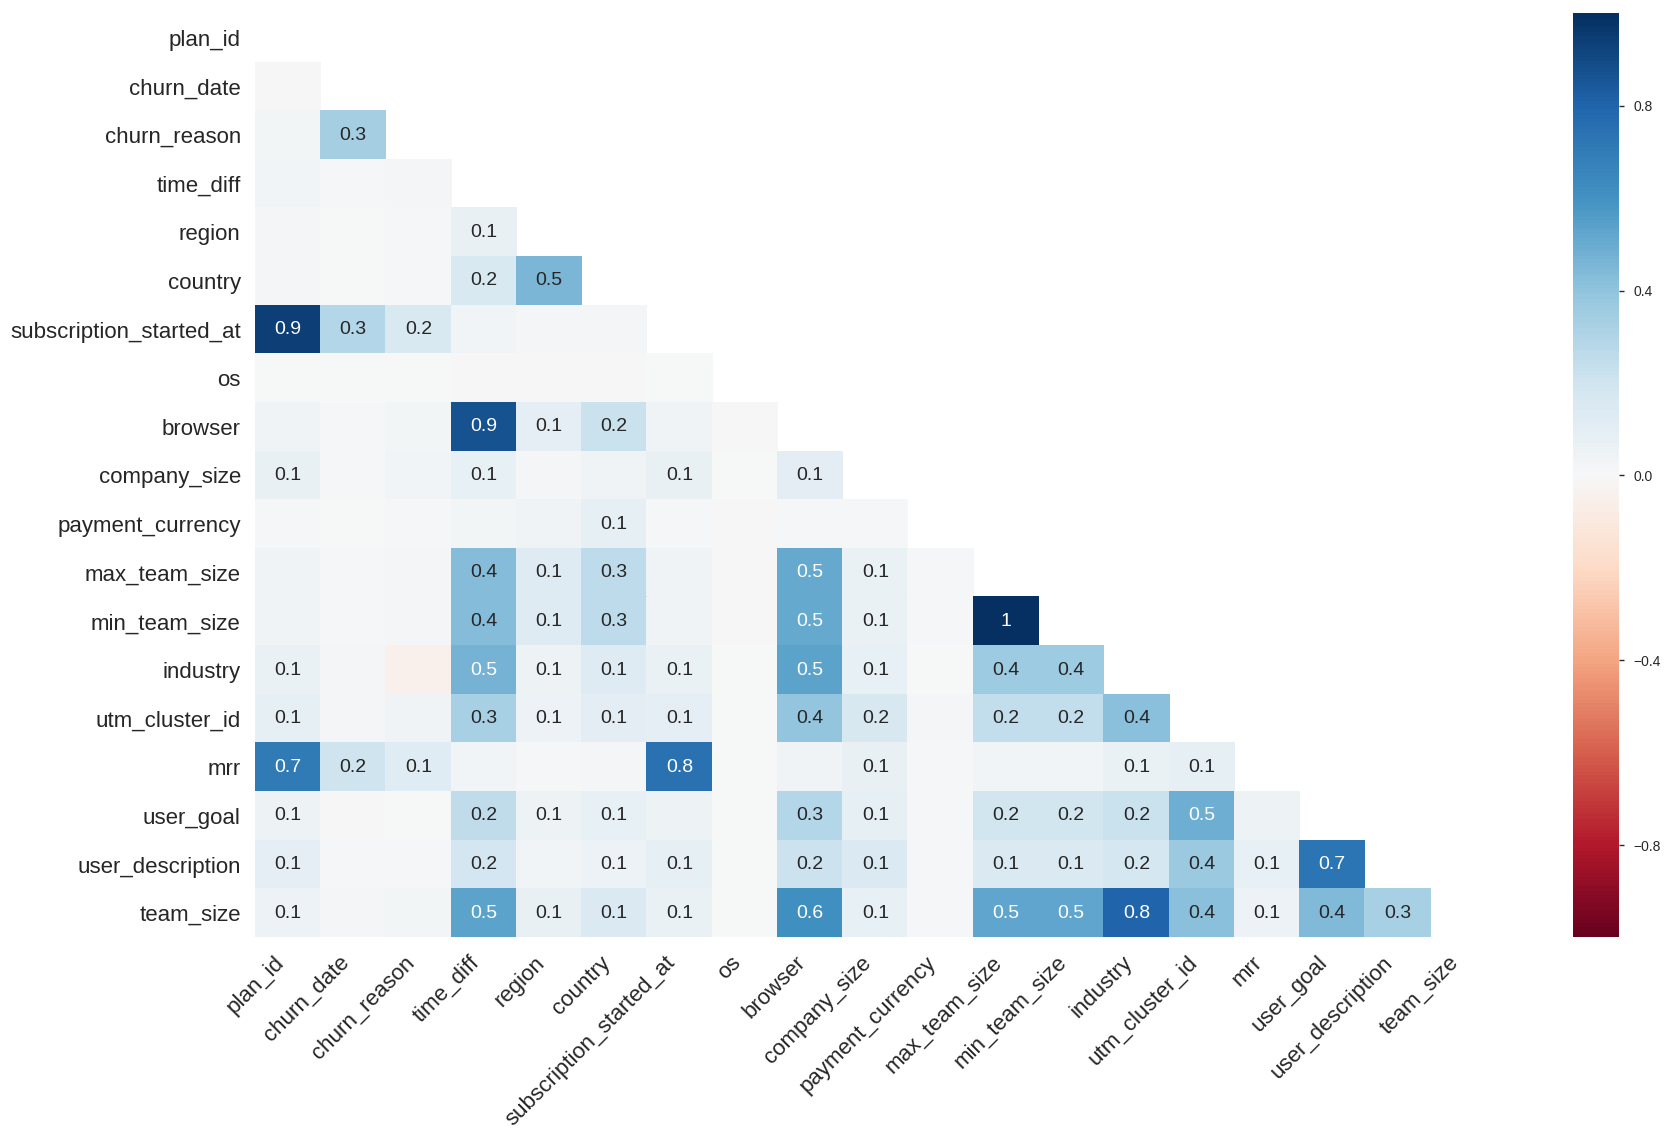

In [194]:
missingno.heatmap(accounts_df)

Lets take only the features with over 50% missing data

In [0]:
columns_index_tp_keep = np.where((accounts_df.isnull().mean()) < 0.5)[0]
accounts_df = accounts_df[accounts_df.columns[columns_index_tp_keep]]

In [196]:
accounts_df.shape

(1361978, 19)

We left with 18 columns.

Now lets also remove rows with less than 50% information on the features that left.

In [197]:
np.count_nonzero(accounts_df.isnull().mean(axis=1) > 0.5)

0

let take column for example and try to handle the missing values in it.
For example lets take `min_team_size`

In [198]:
accounts_df['min_team_size'].isnull().mean()

0.10837913681425104

We can see we have about 11% missing values, 

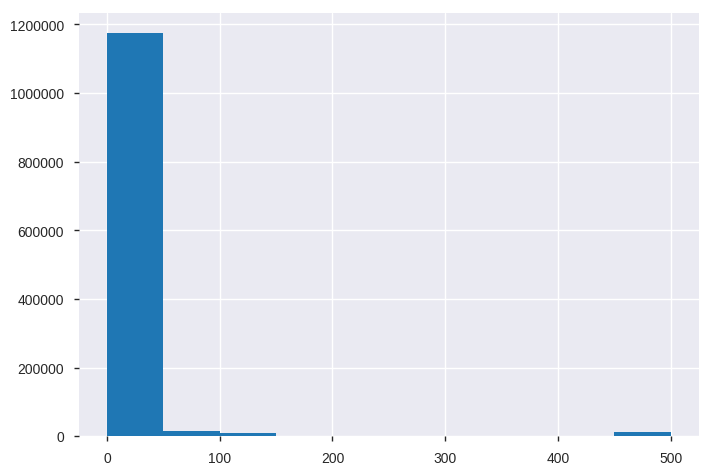

In [199]:
accounts_df['min_team_size'].hist()

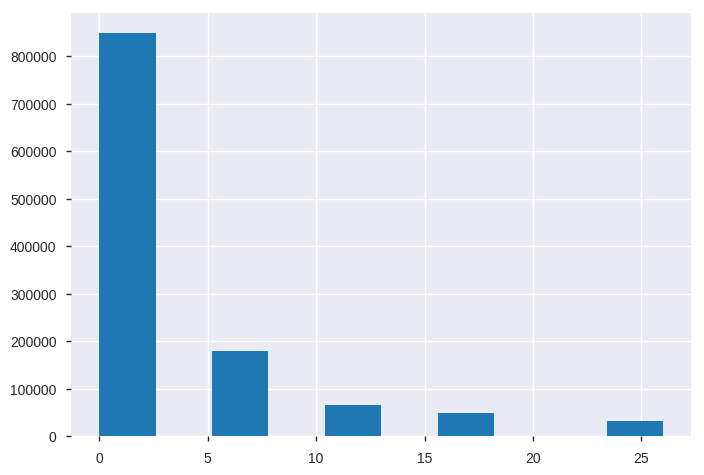

In [200]:
accounts_df['min_team_size'].apply(lambda x: x if x < 50 else np.nan).hist()

Now lets handle the missing values.<BR>There is a lot of possabilities to handle missing data, lets see one way:

In [201]:
# fill missing data with mean or median
median = accounts_df['min_team_size'].median()
mean = accounts_df['min_team_size'].mean()
print('Median is {}\nMean is {}'.format(median, mean))

Median is 2.0
Mean is 10.912485342169754


In [0]:
# fill missing data with mean value
new_min_team_size_column = accounts_df['min_team_size'].fillna(accounts_df['min_team_size'].median())

In [203]:
print(np.count_nonzero(new_min_team_size_column.isnull().mean()))


0


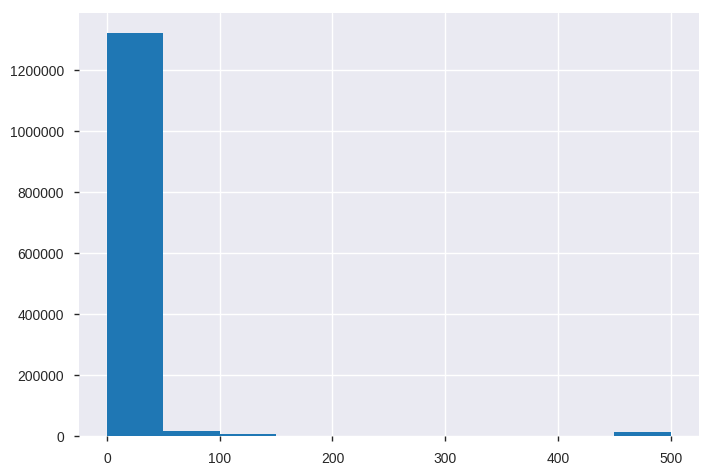

In [204]:
new_min_team_size_column.hist()

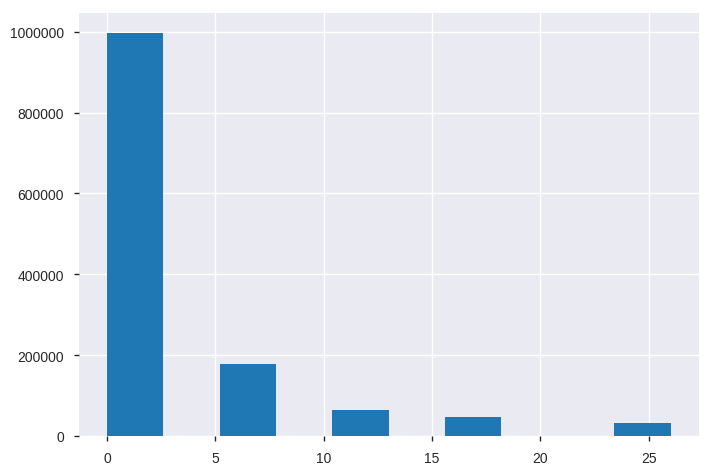

In [205]:
new_min_team_size_column.apply(lambda x: x if x < 50 else np.nan).hist()

In [206]:
new_min_team_size_column.value_counts()

2.00      584772
1.00      367195
6.00      178895
11.00      65680
16.00      48538
0.00       44259
26.00      33056
51.00      16567
500.00     13558
101.00      9448
15.00          3
8.00           3
50.00          2
3.00           2
Name: min_team_size, dtype: int64

We can also give some default value like "-1" - which isn't a valid value but the algorith might get the semantic value.<BR>Lets do also some example with a categorical column - `browser`

In [207]:
accounts_df['browser'].isnull().mean()

0.14107129483736155

lets see the different values we have:

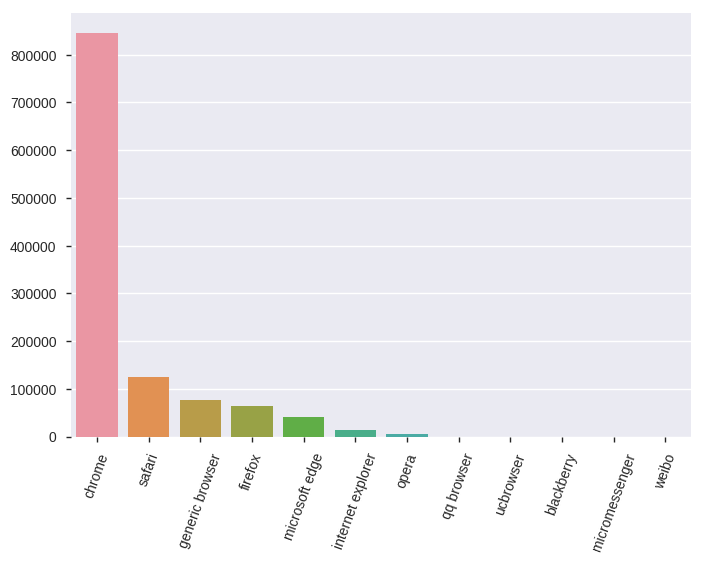

In [208]:
sns.barplot(x=accounts_df['browser'].value_counts().index, y=accounts_df['browser'].value_counts().values)
_ = plt.xticks(rotation=70)

Most of the accounts using chrome, so lets try and fill the values with the most common one:

In [0]:
# fill missing data with common value
new_browser_column = accounts_df['browser'].fillna('chrome')

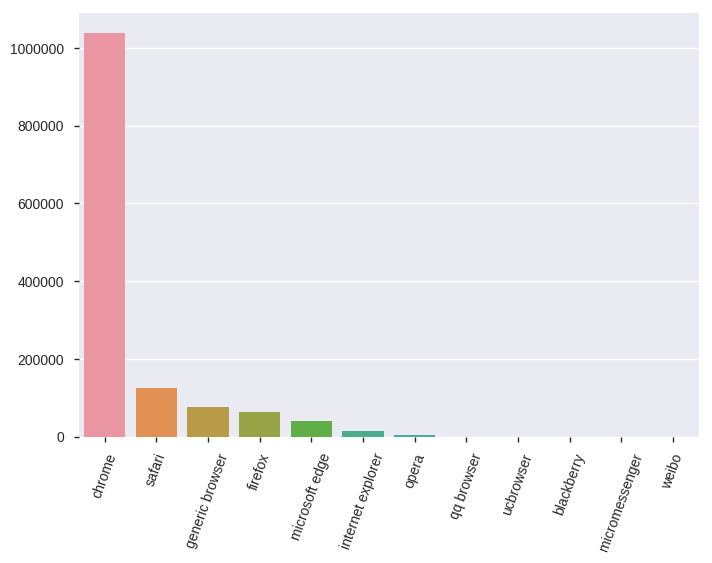

In [210]:
sns.barplot(x=new_browser_column.value_counts().index, y=new_browser_column.value_counts().values)
_ = plt.xticks(rotation=70)

There is another option for example to predict the missing value. you can try it yourself :) 

In [0]:
accounts_df['browser'] = accounts_df['browser'].fillna('chrome')
accounts_df['min_team_size'] = accounts_df['min_team_size'].fillna(accounts_df['min_team_size'].median())

## Your turn

Take one column and check his "missigness", and try to solve it.

# Handling categorical columns

Lets see 2 options to handle categorical data: LabelEncoder and OneHotEncoder

## LabelEncoder

In [0]:
# labelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_browser = le.fit_transform(accounts_df['browser'])

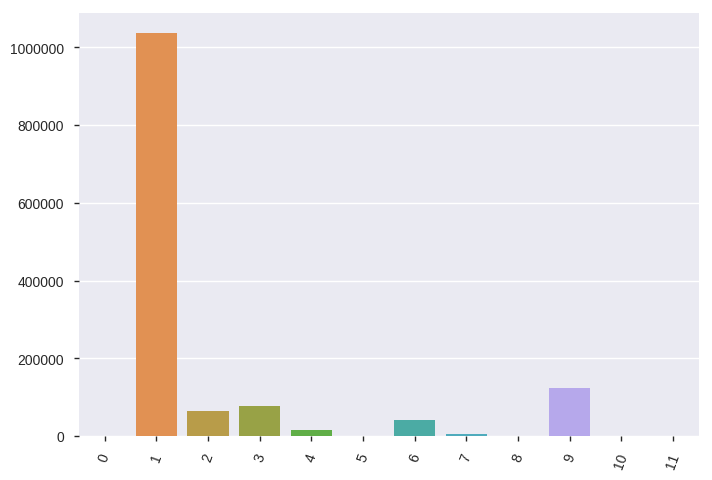

In [213]:
sns.barplot(x=list(Counter(encoded_browser).keys()), y=list(Counter(encoded_browser).values()))
_ = plt.xticks(rotation=70)

In [214]:
le.classes_

array(['blackberry', 'chrome', 'firefox', 'generic browser',
       'internet explorer', 'micromessenger', 'microsoft edge', 'opera',
       'qq browser', 'safari', 'ucbrowser', 'weibo'], dtype=object)

So basically the situation right now is that `firefox > chrome` and `safari > opera` - which its something that in a lot of cases isn't desired.

## One Hot Encoding

A different option is to use OneHotEncoding.<BR>We can use sklearn [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) and also pandas [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [215]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
ohe_browser = enc.fit_transform(encoded_browser.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [216]:
ohe_browser

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [217]:
pd.get_dummies(accounts_df['browser'])

,blackberry,chrome,firefox,generic browser,internet explorer,micromessenger,microsoft edge,opera,qq browser,safari,ucbrowser,weibo
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0


In [218]:
pd.get_dummies(accounts_df, columns=['browser'])

,account_id,account_name,created_at,trial_start,time_diff,region,country,paying,device,os,collection_21_days,payment_currency,max_team_size,min_team_size,industry,team_size,lead_score,created_trial_delta,browser_blackberry,browser_chrome,browser_firefox,browser_generic browser,browser_internet explorer,browser_micromessenger,browser_microsoft edge,browser_opera,browser_qq browser,browser_safari,browser_ucbrowser,browser_weibo
0,1.00,"Gardner, Barron and Keller",2019-01-01 00:01:15,2019-01-01 00:01:15,11.00,New South Wales,AU,0,desktop,windows,0,AUD,5.00,2.00,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2.00,Dunn Ltd,2019-01-01 00:01:52,2019-01-01 00:01:52,nan,New Jersey,US,0,mobile,ios,0,USD,5.00,2.00,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3.00,Boone Inc,2019-01-01 00:03:12,2019-01-01 00:03:12,-6.00,Louisiana,US,0,desktop,windows,0,USD,1.00,1.00,Other,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4.00,"Christian, Carroll and Davis",2019-01-01 00:04:11,2019-01-01 00:04:11,nan,Tel Aviv,IL,0,mobile,android,0,USD,nan,2.00,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5.00,Brooks-Oliver,2019-01-01 00:04:21,2019-04-04 11:09:12,-5.00,North Carolina,US,0,desktop,chrome_os,0,USD,1.00,1.00,Design,1,0,11,0,1,0,0,0,0,0,0,0,0,0,0
5,6.00,"Martinez, Romero and Sullivan",2019-01-01 00:04:25,2019-01-01 00:04:25,-5.00,Michigan,US,0,desktop,mac,0,USD,5.00,2.00,Finance,2-5,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,8.00,Bell-Becker,2019-01-01 00:05:50,2019-05-16 03:54:36,nan,Jerusalem,IL,0,mobile,android,0,USD,nan,2.00,NaN,NaN,0,3,0,1,0,0,0,0,0,0,0,0,0,0
7,9.00,Cain-Davis,2019-01-01 00:06:38,2019-01-01 00:06:38,nan,Al Asimah,KW,0,mobile,ios,0,USD,0.00,0.00,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,10.00,"Gilmore, Conner and Hickman",2019-01-01 00:08:41,2019-01-01 00:08:41,2.00,Central Macedonia,GR,0,mobile,android,0,EUR,25.00,16.00,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,11.00,Chase Group,2019-01-01 00:08:52,2019-01-01 00:08:52,-8.00,British Columbia,CA,0,desktop,windows,0,CAD,500.00,500.00,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Your turn

Identify one column that got categorical data, visualize it and handle it

Briefly you will learn a little bit about the internals of different algorithms like RandomForest and Linear Regression. In real life you'll rarely need to write from scratch your algorithm, and usually you'll use some kind of import to help you.<BR>Also the preprocessing although its fun to do manually to get familiar with your data more - there is other options to ease your process :) 

#Pandas profiling

In [0]:
import pandas_profiling

In [220]:
pandas_profiling.ProfileReport(accounts_df) # in Colab the report seem a little bit off, you can download it with to_file

Number of variables,19
Number of observations,1361978
Total Missing (%),5.4%
Total size in memory,197.4 MiB
Average record size in memory,152.0 B
Numeric,6
Categorical,11
Boolean,2
Date,0
Text (Unique),0
Rejected,0


In [0]:
# example of downloading - 
# from google.colab import drive
# drive.mount('/content/gdrive')
#
# pandas_profiling.ProfileReport(accounts_df).to_file('/content/gdrive/My Drive/df_profiling_report.html')
#

# Enrichment from other datasource

We have more dataset beside this accounts csv file. lets explore Users also.

## Users

In [222]:
users_df.head()

,account_id,user_id,email,name,created_at,is_admin,pending,enabled,became_active_at,time_diff,city,region,country,serial_number,has_photo,device,os,browser,language,seniority,has_phone
0,1.00,1.00,john06@gmail.com,Jessica Ward,2018-12-31 23:58:17,1.00,0.00,1.00,2019-01-01 00:01:16,11.00,Warrawee,New South Wales,AU,1.00,1.00,desktop,windows,microsoft edge,NaN,NaN,1.00
1,2.00,2.00,doylematthew@gmail.com,Ana Spears,2018-12-31 23:57:44,1.00,0.00,1.00,2019-01-01 00:01:53,-5.00,Old Bridge,New Jersey,US,1.00,1.00,mobile,ios,NaN,NaN,NaN,1.00
2,2.00,3.00,valeriewood@martinez-obrien.com,Tami Davidson,2019-01-01 00:17:24,0.00,0.00,1.00,2019-01-01 01:14:41,-5.00,New York,New York,US,2.00,1.00,mobile,android,NaN,NaN,NaN,1.00
3,3.00,4.00,wroberts@gmail.com,Robert Myers,2019-01-01 00:00:09,1.00,0.00,1.00,2019-01-01 00:03:12,-6.00,New Iberia,Louisiana,US,1.00,1.00,desktop,windows,chrome,NaN,NaN,1.00
4,4.00,5.00,ian30@gmail.com,Julie Juarez,2019-01-01 00:02:56,1.00,0.00,1.00,2019-01-01 00:04:11,nan,Tel Aviv,Tel Aviv,IL,1.00,1.00,mobile,android,NaN,NaN,NaN,1.00


In [223]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140258 entries, 0 to 2140257
Data columns (total 21 columns):
account_id          float64
user_id             float64
email               object
name                object
created_at          object
is_admin            float64
pending             float64
enabled             float64
became_active_at    object
time_diff           float64
city                object
region              object
country             object
serial_number       float64
has_photo           float64
device              object
os                  object
browser             object
language            object
seniority           object
has_phone           float64
dtypes: float64(9), object(12)
memory usage: 342.9+ MB


In [224]:
users_df['account_id'].value_counts()

21,806.00       240
128,067.00      234
279,656.00      232
256,380.00      231
1,092,668.00    219
436,580.00      214
142,191.00      211
80,906.00       201
41,114.00       197
291,044.00      191
40,718.00       191
602,168.00      190
16,758.00       184
298,959.00      174
269,781.00      173
16,621.00       171
636,248.00      171
562,655.00      169
40,783.00       166
312,345.00      159
1,024,316.00    156
270,440.00      155
239,574.00      154
306,360.00      153
1,115,194.00    150
40,987.00       149
42,563.00       148
41,821.00       148
49,608.00       147
43,398.00       147
               ... 
1,022,685.00      1
1,022,686.00      1
1,022,687.00      1
1,022,689.00      1
1,022,679.00      1
1,022,691.00      1
1,022,692.00      1
1,022,693.00      1
1,022,694.00      1
1,022,695.00      1
1,022,696.00      1
1,022,680.00      1
1,022,678.00      1
1,022,655.00      1
1,022,665.00      1
1,022,657.00      1
1,022,658.00      1
1,022,659.00      1
1,022,661.00      1


In [225]:
users_df.groupby('account_id').get_group(279656.0)

,account_id,user_id,email,name,created_at,is_admin,pending,enabled,became_active_at,time_diff,city,region,country,serial_number,has_photo,device,os,browser,language,seniority,has_phone
432449,"279,656.00","454,228.00",apruitt@day.com,Robyn Garcia,2019-02-02 11:21:55,1.00,0.00,1.00,2019-02-02 11:24:08,8.00,Singapore,Central Singapore Community Development Council,SG,1.00,1.00,desktop,mac,chrome,NaN,NaN,1.00
432450,"279,656.00","454,229.00",austinnguyen@day.com,Michelle Price,2019-02-02 11:24:57,1.00,0.00,1.00,2019-03-27 06:03:35,5.50,Kachiguda,INDIA,IN,2.00,1.00,mobile,android,chrome,NaN,NaN,1.00
432451,"279,656.00","454,230.00",davidtyler@day.com,Brent Thompson,2019-02-02 11:24:57,0.00,0.00,1.00,2019-02-02 11:38:54,8.00,Singapore,Central Singapore Community Development Council,SG,3.00,1.00,mobile,android,chrome,NaN,executive,1.00
432452,"279,656.00","454,231.00",ifarmer@day.com,Denise Davis,2019-02-25 16:51:51,0.00,0.00,1.00,2019-02-25 16:53:02,8.00,Singapore,Central Singapore Community Development Council,SG,4.00,1.00,desktop,windows,chrome,NaN,manager,1.00
432453,"279,656.00","454,232.00",transusan@smith.biz,Kathy Bates,2019-02-25 16:58:04,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,5.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00
432454,"279,656.00","454,233.00",toddkrystal@smith.biz,Kathy Bates,2019-02-25 16:59:47,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,6.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00
432455,"279,656.00","454,234.00",tracie88@smith.biz,Kathy Bates,2019-02-25 16:59:59,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,7.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00
432456,"279,656.00","454,235.00",lisagarcia@smith.biz,Kathy Bates,2019-02-25 17:00:14,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,8.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00
432457,"279,656.00","454,236.00",townsendtammy@smith.biz,Kathy Bates,2019-02-25 17:03:09,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,9.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00
432458,"279,656.00","454,237.00",nashlisa@smith.biz,Kathy Bates,2019-02-25 17:03:10,0.00,1.00,0.00,NaN,nan,NaN,NaN,NaN,10.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00


## Number of different timezones

Example of feature to add from users:
How many different timezones there is in the account

In [226]:
users_df.groupby('account_id')['time_diff'].nunique()

account_id
1.00            1
2.00            1
3.00            1
4.00            0
5.00            1
6.00            1
8.00            0
9.00            1
10.00           1
11.00           1
12.00           1
13.00           1
14.00           1
15.00           1
16.00           1
17.00           1
18.00           0
19.00           1
20.00           1
21.00           1
22.00           1
23.00           1
24.00           1
25.00           1
26.00           1
27.00           1
28.00           1
29.00           1
30.00           1
31.00           1
               ..
1,433,628.00    1
1,433,629.00    2
1,433,630.00    1
1,433,631.00    1
1,433,632.00    1
1,433,633.00    1
1,433,634.00    1
1,433,635.00    1
1,433,636.00    1
1,433,637.00    2
1,433,638.00    1
1,433,639.00    1
1,433,640.00    1
1,433,641.00    1
1,433,642.00    0
1,433,643.00    1
1,433,644.00    1
1,433,646.00    1
1,433,647.00    1
1,433,648.00    1
1,433,649.00    1
1,433,650.00    1
1,433,651.00    0
1,433,652.00    1

In [0]:
accounts_df.set_index('account_id', inplace=True)

## Ratio of @gmail users

Another example: ratio of @gmail users in the account:

In [228]:
users_df.groupby('account_id').get_group(4.0)['email']

4    ian30@gmail.com
Name: email, dtype: object

In [0]:
def count_gmails(series):
  return series.apply(lambda x: '@gmail' in x).mean()

In [230]:
count_gmails(users_df.groupby('account_id').get_group(4.0)['email'])

1.0

In [0]:
gmail_ratio = users_df.groupby('account_id')['email'].agg(count_gmails)

In [232]:
gmail_ratio

account_id
1.00           1.00
2.00           0.50
3.00           1.00
4.00           1.00
5.00           1.00
6.00           0.00
8.00           1.00
9.00           1.00
10.00          1.00
11.00          1.00
12.00          0.00
13.00          0.00
14.00          0.00
15.00          1.00
16.00          0.00
17.00          0.00
18.00          1.00
19.00          0.00
20.00          0.00
21.00          0.00
22.00          1.00
23.00          0.00
24.00          0.00
25.00          1.00
26.00          0.00
27.00          1.00
28.00          1.00
29.00          0.00
30.00          0.00
31.00          1.00
               ... 
1,433,628.00   0.00
1,433,629.00   0.00
1,433,630.00   0.00
1,433,631.00   0.00
1,433,632.00   1.00
1,433,633.00   0.00
1,433,634.00   0.00
1,433,635.00   0.00
1,433,636.00   1.00
1,433,637.00   0.00
1,433,638.00   0.00
1,433,639.00   0.00
1,433,640.00   1.00
1,433,641.00   1.00
1,433,642.00   0.00
1,433,643.00   0.50
1,433,644.00   1.00
1,433,646.00   0.00
1,433,647

In [0]:
diff_timezones = users_df.groupby('account_id')['time_diff'].nunique()
accounts_df = accounts_df.merge(diff_timezones, left_index=True, right_index=True)
accounts_df = accounts_df.merge(gmail_ratio, left_index=True, right_index=True)

# Pipelines

pipeline is a great tool that sometime can be an overkill but it help you keep on an ordered and documented way of preprocessing your data.

lets see with which colum we ended with:

In [234]:
accounts_df.describe(include='all')

,account_name,created_at,trial_start,time_diff_x,region,country,paying,device,os,browser,collection_21_days,payment_currency,max_team_size,min_team_size,industry,team_size,lead_score,created_trial_delta,time_diff_y,email
count,1360570,1360570,1360570,"1,132,187.00",1273478,1342302,"1,360,570.00",1360570,1360485,1360570,"1,360,570.00",1353648,"1,213,267.00","1,360,570.00",870607,954655,"1,360,570.00","1,360,570.00","1,360,570.00","1,360,570.00"
unique,511927,1291965,1294668,nan,3578,236,nan,3,7,12,nan,8,nan,nan,32,18,nan,nan,nan,nan
top,Smith PLC,2019-04-29 13:35:08,2019-04-29 13:35:08,nan,Sao Paulo,US,nan,desktop,windows,chrome,nan,USD,nan,nan,Other,2-5,nan,nan,nan,nan
freq,4537,5,6,nan,54021,314456,nan,968231,716178,1035789,nan,1047551,nan,nan,103574,352270,nan,nan,nan,nan
mean,NaN,NaN,NaN,-1.44,NaN,NaN,0.02,NaN,NaN,NaN,7.74,NaN,17.59,9.95,NaN,NaN,0.02,1.19,0.95,0.41
std,NaN,NaN,NaN,4.72,NaN,NaN,0.14,NaN,NaN,NaN,102.82,NaN,68.50,50.31,NaN,NaN,0.16,4.66,0.35,0.48
min,NaN,NaN,NaN,-12.00,NaN,NaN,0.00,NaN,NaN,NaN,"-1,440.00",NaN,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00
25%,NaN,NaN,NaN,-5.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,1.00,1.00,NaN,NaN,0.00,0.00,1.00,0.00
50%,NaN,NaN,NaN,-3.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,5.00,2.00,NaN,NaN,0.00,0.00,1.00,0.00
75%,NaN,NaN,NaN,2.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,10.00,6.00,NaN,NaN,0.00,0.00,1.00,1.00


In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def identity(x):
  return x

numeric_features = ['collection_21_days', 'max_team_size', 'min_team_size', 'email', 'time_diff_x', 'time_diff_y', 'created_trial_delta']
numeric_transformer = Pipeline(verbose=True, steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_features = ['country', 'device', 'os', 'browser', 'industry', 'payment_currency', 'team_size']
categorical_transformer = Pipeline(verbose=True, steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(sparse=False))])

categorical_transformer_no_ohe = Pipeline(verbose=True, steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING'))])

identity_features = ['paying', 'lead_score']
identity_transformer = Pipeline(verbose=True, steps=[
    ('identity', FunctionTransformer(identity))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('identity', identity_transformer, identity_features)])

preprocessor_without_ohe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_no_ohe', categorical_transformer_no_ohe, categorical_features),
        ('identity', identity_transformer, identity_features)])

In [0]:
def get_column_names(pipeline):    
    col_name = []
    for transformer in pipeline.named_steps['preprocessor'].transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
      
        if transformer[0] == 'cat':
          col_name += list(transformer[1].steps[1][1].get_feature_names())
        else:
          col_name += transformer[2]
    return col_name

In [0]:
def pack_transformation(preprocessor, df):
  clf = Pipeline(steps=[('preprocessor', preprocessor)])
  transformed_data = clf.fit_transform(df)
  column_names = get_column_names(clf)
  return pd.DataFrame(transformed_data, columns=column_names)

In [248]:
df_new = pack_transformation(preprocessor, accounts_df)

[Pipeline] ........... (step 1 of 1) Processing imputer, total=   0.3s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.5s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   4.6s
[Pipeline] .......... (step 1 of 1) Processing identity, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [249]:
df_new_without_ohe = pack_transformation(preprocessor_without_ohe, accounts_df)

[Pipeline] ........... (step 1 of 1) Processing imputer, total=   0.3s
[Pipeline] ........... (step 1 of 1) Processing imputer, total=   0.5s
[Pipeline] .......... (step 1 of 1) Processing identity, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [0]:
df_new_200K = df_new.sample(200000).reset_index()

In [251]:
import joblib

joblib.dump(df_new, 'preprocessed_data.jblib', compress=3)
joblib.dump(df_new_200K, 'preprocessed_data_200K.jblib', compress=3)
joblib.dump(df_new_without_ohe, 'preprocessed_data_no_ohe.jblib', compress=3)

['preprocessed_data_no_ohe.jblib']

In [0]:
# def get_column_types(pipeline):    
#     col_types = []
#     for transformer in pipeline.named_steps['preprocessor'].transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
      
#         if transformer[0] == 'cat':
#           col_types += len(list(transformer[1].steps[1][1].get_feature_names())) * ['object']
#         elif transformer[0] == 'cat_no_ohe':
#           col_types += len(transformer[2])*['object']
#         else:
#           col_types += len(transformer[2])*['float64']
#     return col_types